# Learning geometry of geodesics

This is the work done with Samuel Gruffaz on using RKHS to learn the shape of the geodesics.

In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import sys, os


os.chdir("/Users/samuel.gruffaz/Documents/PEcollab")
sys.path.append("/Users/samuel.gruffaz/Documents/PEcollab")
from leaspy.api import Leaspy

from leaspy import Leaspy, Data, AlgorithmSettings, Plotter, Dataset, IndividualParameters
from leaspy.models.utils.attributes.attributes_factory import AttributesFactory
from leaspy.algo.algo_factory import AlgoFactory




In [2]:
def generate_data(model, n_individuals, nb_visits_min, nb_visits_mean, window):
    # Sampling individuals :

    N = n_individuals

    individuals = []

    data = [[], []] + [[] for k in range(model.dimension)]

    for i in range(N):
        tau = np.random.normal(loc=model.parameters['tau_mean'], scale=model.parameters['tau_std'])
        xi = np.random.normal(loc=model.parameters['xi_mean'], scale=model.parameters['xi_std'])
        n_tpts = nb_visits_min + np.random.binomial(2 * (nb_visits_mean-nb_visits_min),0.5)
        tpts = np.sort((np.random.normal(0., 1., size=(n_tpts)) * window) + tau)
        timepoints = torch.tensor(tpts, dtype=float)
        sources = None
        if model.source_dimension is not None:
            sources = np.random.normal(loc=model.parameters['sources_mean'], scale=model.parameters['sources_std'], size=(model.source_dimension))
            values = model.compute_individual_tensorized(timepoints, {"tau":torch.tensor(tau), "xi":torch.tensor(xi), "sources":torch.Tensor(sources)}).detach().numpy()
        else:   
            values = model.compute_individual_tensorized(timepoints, {"tau":torch.tensor(tau), "xi":torch.tensor(xi)}).detach().numpy()
        values = values + np.random.normal(0., model.parameters['noise_std'], size=(n_tpts, model.dimension))
        individuals.append({"idx":i+1, "tau":tau, "xi":xi, "tpts":tpts, "sources":sources, "values":values})
        data[0] += [i+1] * n_tpts
        data[1] += list(tpts)
        for k in range(model.dimension):
            data[2+k] += list(values[0, :, k])
    data = np.array(data).T
    df = pd.DataFrame(data, columns=['ID', 'TIME']+["Y"+str(k+1) for k in range(model.dimension)])
    df.set_index(['ID', 'TIME'], inplace=True)
    return df, individuals

def plot_generative(ax, individuals, model1, nb_ind_plot, dimension):

    for i in range(nb_ind_plot):
        params = individuals[i]
        mean_par = {key:torch.tensor(params[key])for key in ["tau", "xi"]}
        mean_par["sources"] = torch.Tensor(params["sources"])
        t = torch.tensor(np.linspace(np.min(params["tpts"])-1.,np.max(params["tpts"])+1.,100), dtype=torch.float)

        trajectory = model1.compute_individual_tensorized(t, mean_par).squeeze(0)
        for j in range(dimension):
            ax[i,j].plot(individuals[i]['tpts'], individuals[i]['values'][0,:,j], "o")
            ax[i,j].plot(t, trajectory[..., j])

def plot_fit(ax, results, model, individuals, nb_ind_plot, dimension):

    for i in range(nb_ind_plot):
        params = results._individual_parameters[results._indices[i]]
        params["tpts"] = individuals[i]["tpts"]
        mean_par = {key:torch.tensor(params[key])for key in ["tau", "xi"]}
        mean_par["sources"] = torch.Tensor(params["sources"])
        t = torch.tensor(np.linspace(np.min(params["tpts"])-1.,np.max(params["tpts"])+1.,100), dtype=torch.float)

        trajectory = model.compute_individual_tensorized(t, mean_par).squeeze(0)
        for j in range(dimension):
            ax[i,j].plot(t, trajectory[..., j])

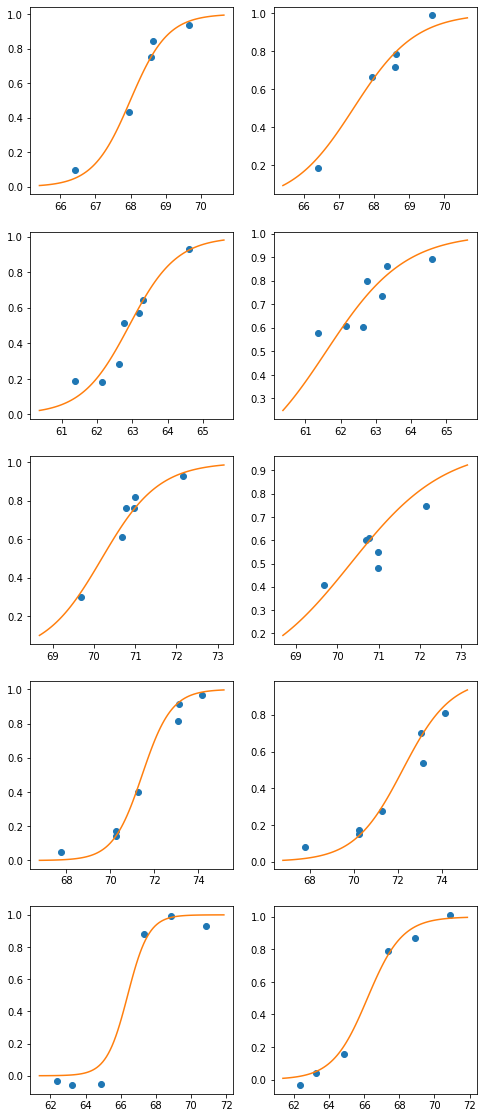

In [3]:
leaspy = Leaspy('linearB')
dimension = 2
sources_dimension = 1
leaspy.model.parameters = {'g': [0., 1.],
                           'v0':[.5, 0.],
                           'betas':[[1.]],
                           'tau_mean': 70., 'tau_std': 5.,
                           'xi_mean': 0., 'xi_std': .1,
                           'sources_mean': 0.,
                           'sources_std': 1.,
                           'noise_std': [.07]}
model1 = leaspy.model
model1.dimension = dimension
model1.source_dimension = sources_dimension
model1.parameters = {key: torch.tensor(val) for key, val in model1.parameters.items()}
model1.attributes = AttributesFactory.attributes(model1.name, dimension, sources_dimension)
model1.attributes._compute_positions(model1.parameters)
model1.attributes._compute_velocities(model1.parameters)
model1.attributes._compute_betas(model1.parameters)
model1.attributes._compute_orthonormal_basis()
model1.attributes._compute_mixing_matrix()
model1.is_initialized = True

periode = 15.
amplitude = 2.
model1.B = lambda x : 1./(1.+torch.exp(-x))

n_individuals = 100
nb_visits_min = 2
nb_visits_mean = 6
window = 2.

data, individuals = generate_data(model1, n_individuals, nb_visits_min, nb_visits_mean, window)

leaspy_data = Data.from_dataframe(data)

nb_ind_plot = 5

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(dimension * 4, nb_ind_plot * 4))

plot_generative(ax, individuals, model1, nb_ind_plot, dimension)
plt.show()


The standard deviation of the noise at the end of the calibration is:
0.1337

Calibration took: 5s

The standard deviation of the noise at the end of the personalization is:
0.1184

Personalization scipy_minimize took: 8s
erreur projection
0.003212634
1
2
temps opti quadra
0.020338999999999885


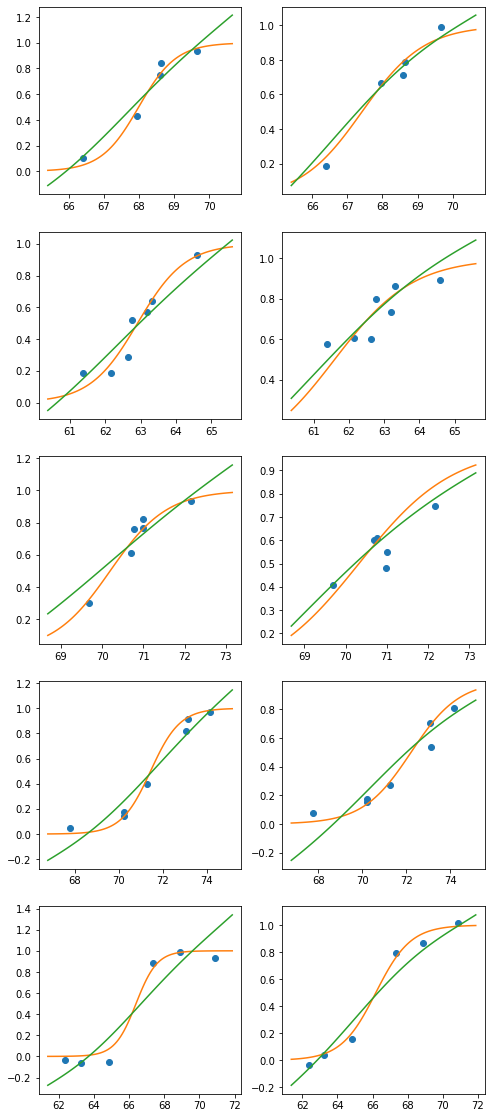

In [4]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 10,"nb_compose":2}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE')
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
    
plt.show()

In [9]:

from leaspy.models.utils.OptimB import *

def dicho(a,b,c,f,err=10**(-2)):
    mi=a
    ma=b
    pivot=(mi+ma)/2
    dec=abs(f(pivot)-c)
    k=0
    while dec>err and k<20:
        k=k+1
        comp=f(pivot)
        if comp>c:
            mi=pivot
        else:
            ma=pivot
        pivot=(mi+ma)/2
        dec=abs(f(pivot)-c)
    return pivot


import time
import scipy.linalg as LA
def optim_solver2(X, Y, K, indices, dim, sigma):
    t1=time.clock()
    KCC = K[indices].detach().numpy()
    KG=K.detach().numpy()

    Kred=KG.transpose()@KG
    
    X_ = X.detach().numpy()
    Y_ = Y.detach().numpy()

    Const=Y_-X_
    DD=KG.transpose()@Const
    lambd=1
    lambdmin=1
    Mat=lambd*KCC+Kred
    
    w,V=LA.eigh(Mat)
    delta = np.abs(Mat - (V * w).dot(V.T))
    print("erreur projection")
    print(LA.norm(delta, ord=2))

    W=np.linalg.solve(Mat,DD)

    contrainte=sigma**2/dim


    g=lambda w: np.trace(w.transpose()@KCC@w)

    while g(W)>contrainte:
        print(lambd)
        lambd,lambdmin=lambd*2,lambd
        Mat=lambd*KCC+Kred
        W=np.linalg.solve(Mat,DD)
    #rajouter ensuite une recherche dicotomique du lambda optimal
    f=lambda l: np.trace(np.linalg.solve(l*KCC+Kred,DD).transpose()@KCC@np.linalg.solve(l*KCC+Kred,DD))
    lopt=dicho(lambdmin,lambd,contrainte,f)
    Mat=lopt*KCC+Kred
    W=np.linalg.solve(Mat,DD)
    t2=time.clock()
    print("temps opti quadra")
    print(t2-t1)
    return W

def outer_iteration3(leaspy_test, leaspy_data, dataset, meta_settings):
    
    fit_settings = meta_settings["fit"]
    leaspy_test.fit(leaspy_data, algorithm_settings=fit_settings)

    perso_settings = meta_settings["personalize"]
    results = leaspy_test.personalize(leaspy_data, perso_settings)
    _, ind_params = results.to_pytorch()
    
    X = leaspy_test.model.compute_individual_tensorized(dataset.timepoints, ind_params)
    Y = dataset.values

    X_acc = []
    Y_acc = []

    for i in range(X.shape[0]):
        X_acc.append(X[i, :dataset.nb_observations_per_individuals[i]])
        Y_acc.append(Y[i, :dataset.nb_observations_per_individuals[i]])    

    X = torch.cat(X_acc)
    Y = torch.cat(Y_acc)
    
    indices = sub_sampling(X, meta_settings["nb_control_points"])
    X_control = X[indices]
    
    K = compute_kernel_matrix(X, meta_settings, X_control)
    
    W_opt = optim_solver2(X, Y, K, indices, leaspy_test.model.dimension, meta_settings["sigma"])
    print(type)
    oldB=leaspy_test.model.B 
    
    leaspy_test.model.B = transformation_B_compose(X_control, W_opt, meta_settings,oldB)
    return results


The standard deviation of the noise at the end of the calibration is:
0.1279

Calibration took: 5s

The standard deviation of the noise at the end of the personalization is:
0.1141

Personalization scipy_minimize took: 8s
erreur projection
0.0027305153
1
2
temps opti quadra
0.006866000000002259
ipykernel_launcher:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
ipykernel_launcher:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

The standard deviation of the noise at the end of the calibration is:
0.1130

Calibration took: 49s

The standard deviation of the noise at the end of the personalization is:
0.1006

Personalization scipy_minimize took: 14s
erreur projection
0.0018570897
1
temps opti quadra
0.005127000000015869
ipykernel_launcher:24: DeprecationWarning: time.clock 

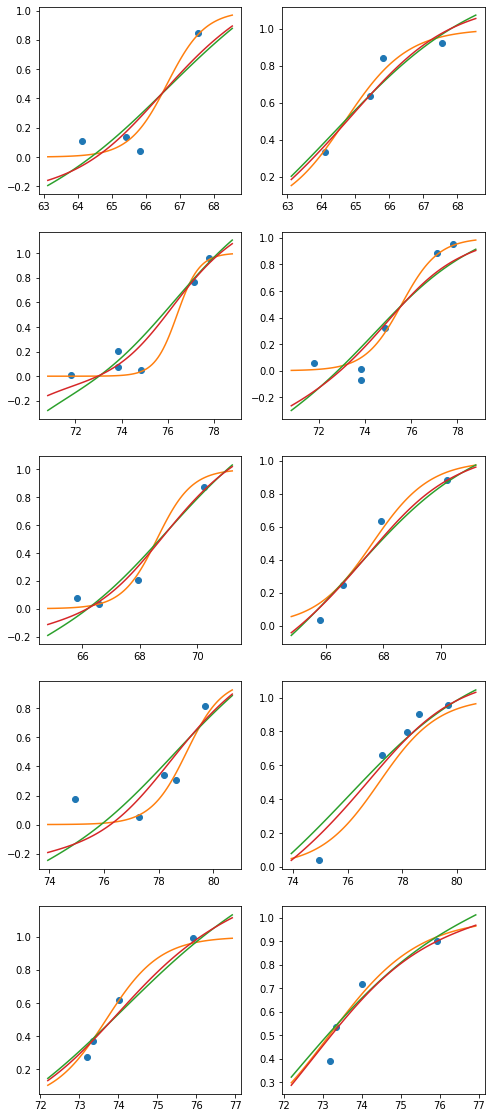

In [11]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 10}
meta_settings["fit"] = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE')
meta_settings["personalize"] = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)

for k in range(2):
    results = outer_iteration3(leaspy_test, leaspy_data, dataset, meta_settings)
    plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
    
plt.show()